# Visualization of Scan Benchmark Results

Should the plots be saved as files?

In [1]:
save_plots = True
file_type = 'png' # 'pdf', 'png' or 'svg' 

### Define some CSV related constants

In [2]:
TYPE_STRING = 1
TYPE_INT = 0
OPERATION_EQUALS = 0
OPERATION_EQUALS_BITSET = 1
OPERATION_EQUALS_DICT = 2
OPERATION_EQUALS_DICT_BITSET = 3
OPERATION_EQUALS_INDEX = 4
OPERATION_EQUALS_INDEX_BITSET = 5
OPERATION_EQUALS_BTREE = 6
OPERATION_LESS_OR_EQUALS = 7
OPERATION_LESS_OR_EQUALS_BITSET = 8
OPERATION_LESS_OR_EQUALS_DICT = 9
OPERATION_LESS_OR_EQUALS_DICT_BITSET = 10
OPERATION_LESS_OR_EQUALS_INDEX = 11
OPERATION_LESS_OR_EQUALS_INDEX_BITSET = 12
OPERATION_LESS_OR_EQUALS_BTREE = 13

### Define functions for scatter plots

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def get_df(filename):
    df = pd.read_csv(filename)
    return df


def get_dataframes_per_operation(dataframe, operation_type):
    if operation_type == 'equals':
        df_raw = dataframe[dataframe.operation == OPERATION_EQUALS]
        df_dict = dataframe[dataframe.operation == OPERATION_EQUALS_DICT]
        df_index = dataframe[dataframe.operation == OPERATION_EQUALS_INDEX]
        df_index_bitset = dataframe[dataframe.operation == OPERATION_EQUALS_INDEX_BITSET]
        df_raw_bitset = dataframe[dataframe.operation == OPERATION_EQUALS_BITSET]
        df_dict_bitset = dataframe[dataframe.operation == OPERATION_EQUALS_DICT_BITSET]
        df_btree = dataframe[dataframe.operation == OPERATION_EQUALS_BTREE]
    elif operation_type == 'less_or_equals':
        df_raw = dataframe[dataframe.operation == OPERATION_LESS_OR_EQUALS]
        df_dict = dataframe[dataframe.operation == OPERATION_LESS_OR_EQUALS_DICT]
        df_index = dataframe[dataframe.operation == OPERATION_LESS_OR_EQUALS_INDEX]
        df_index_bitset = dataframe[dataframe.operation == OPERATION_LESS_OR_EQUALS_INDEX_BITSET]
        df_raw_bitset = dataframe[dataframe.operation == OPERATION_LESS_OR_EQUALS_BITSET]
        df_dict_bitset = dataframe[dataframe.operation == OPERATION_LESS_OR_EQUALS_DICT_BITSET]
        df_btree = dataframe[dataframe.operation == OPERATION_LESS_OR_EQUALS_BTREE]
        df_index_bitset = dataframe[dataframe.operation == OPERATION_LESS_OR_EQUALS_INDEX_BITSET]
    else: raise ValueError('Unsupported operation type: {}'.format(operation_type))

    return df_raw, df_dict, df_index, df_index_bitset, df_raw_bitset, df_dict_bitset, df_btree


def get_mean_durations_per_selectivity(dataframe):
    mean_durations = []
    selectivities = []
    for value in dataframe['selectivity'].unique():
        values = dataframe[dataframe.selectivity == value]
        means = values.median()
        mean_durations.append(means['duration_microseconds'])
        selectivities.append(means['selectivity'])
        
    return mean_durations


def get_mean_durations_by_operation_and_selectivity(df1, df2, df3, df4, df5, df6, df7):
    mean_durations_1 = get_mean_durations_per_selectivity(df1)
    mean_durations_2 = get_mean_durations_per_selectivity(df2)
    mean_durations_3 = get_mean_durations_per_selectivity(df3)
    mean_durations_4 = get_mean_durations_per_selectivity(df4)
    mean_durations_5 = get_mean_durations_per_selectivity(df5)
    mean_durations_6 = get_mean_durations_per_selectivity(df6)
    mean_durations_7 = get_mean_durations_per_selectivity(df7)
    
    return mean_durations_1, mean_durations_2, mean_durations_3, mean_durations_4, mean_durations_5, mean_durations_6, mean_durations_7


def get_comparing_scatter_plot(x, ys, labels, title, markers=['s', 'x'], 
                               colors=['orange', 'orange', 'blue', 'blue', 'green', 'green', 'red' ], 
                               xleft=-0.01, xright=1.01):
    # show duration in milliseconds
    y = [[ i * 0.001 for i in y ] for y in ys ]
    
    fig = plt.figure(figsize=(9, 4))
    ax1 = fig.add_subplot(111)
    max_y = 0
    min_y = 0
    for i in range(len(y)):
        ax1.plot(x, y[i], marker=markers[i % len(markers)], color=colors[i], label=labels[i])
        if max(y[i]) > max_y:
            max_y = max(y[i])
        if min(y[i]) < min_y:
            min_y = min(y[i])
    plt.xlabel('Selectivity')
    plt.ylabel('Median Duration [ms]')
    plt.suptitle(title)
    plt.grid(b=True)
    plt.xlim(left=xleft, right=xright)
    plt.ylim(bottom=min_y - (min_y*0.1), top=max_y + (max_y*0.1))
    
    fig.legend(loc=7)
    fig.subplots_adjust(right=0.75)   

    return fig


def get_selected_median_durations(dataframe, operation_type, methods):
    raw, dic, index, index_bitset, raw_bitset, dic_bitset, btree = get_dataframes_per_operation(dataframe, operation_type)
    raw_mean_durations, raw_bs_mean_durations, dic_mean_durations, dic_bs_mean_durations, index_mean_durations, index_bs_mean_durations, btree_mean_durations = get_mean_durations_by_operation_and_selectivity(raw, raw_bitset, dic, dic_bitset, index, index_bitset, btree)
    durations = []
    method_names = []
    for method in methods:
        if method == 'raw': 
            durations.append(raw_mean_durations)
            method_names.append('Value Scan')
        elif method == 'raw_bs': 
            durations.append(raw_bs_mean_durations)
            method_names.append('Value Scan (BS)')
        elif method == 'dict': 
            durations.append(dic_mean_durations)
            method_names.append('Dict. Scan')
        elif method == 'dict_bs': 
            durations.append(dic_bs_mean_durations)
            method_names.append('Dict. Scan (BS)')
        elif method == 'index': 
            durations.append(index_mean_durations)
            method_names.append('Index Scan')
        elif method == 'index_bs': 
            durations.append(index_bs_mean_durations)
            method_names.append('Index Scan (BS)')
        elif method == 'btree': 
            durations.append(btree_mean_durations)
            method_names.append('B-Tree Scan')
        else: raise ValueError('Unknown method: {}'.format(method))
            
    return durations, method_names


def plot_df(dataframe, column_type, distinct_values, operation_type='equals', comment='', 
            methods=['raw', 'raw_bs', 'dict', 'dict_bs', 'index', 'index_bs', 'btree'], 
            markers=['s', 'x'], colors=['orange', 'orange', 'blue', 'blue', 'green', 'green', 'red' ], 
            xleft=-0.01, xright=1.01):
    dataframe = dataframe.sort_values('selectivity', ascending=True)
    durations, method_names = get_selected_median_durations(dataframe, operation_type, methods)
    selectivities = dataframe['selectivity'].unique()
    runs = int(round(float(dataframe[dataframe.selectivity == dataframe['selectivity'].unique()[0]].shape[0]) / len(method_names)))
    rows = int(round(dataframe.row_count.mean()))
    title = '{} Runs, {} Rows of {}, {} distinct values {}'.format("{:,}".format(runs), "{:,}".format(rows), 
                                                                   column_type, "{:,}".format(distinct_values), comment)
    
    return get_comparing_scatter_plot(selectivities, durations, method_names,title, markers=markers, 
                                      colors=colors, xleft=xleft, xright=xright)

### Make plots for CSV files

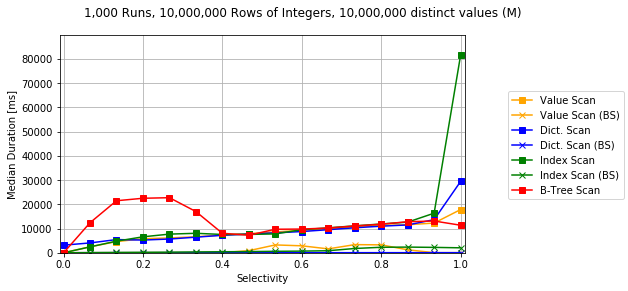

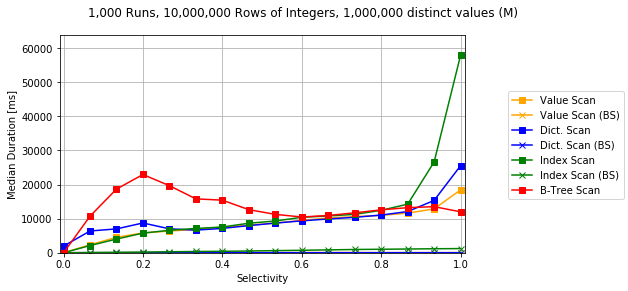

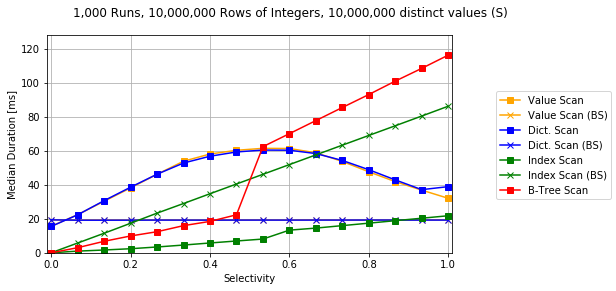

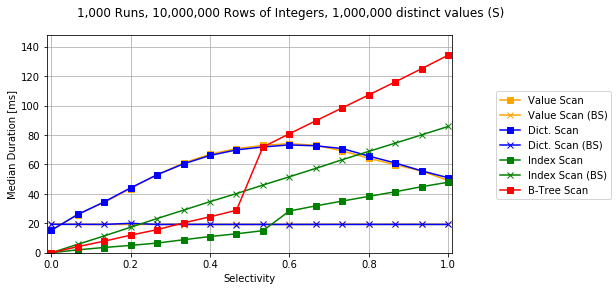

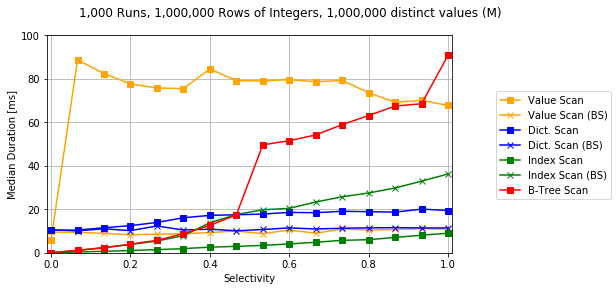

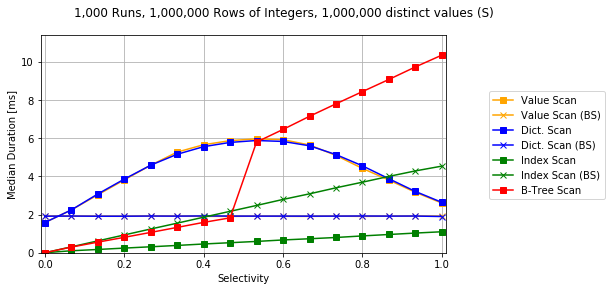

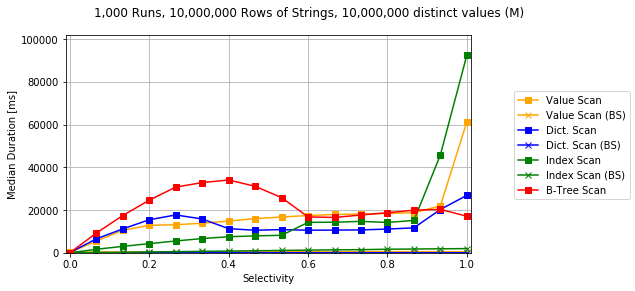

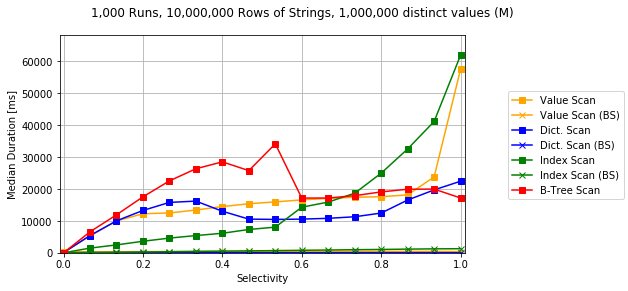

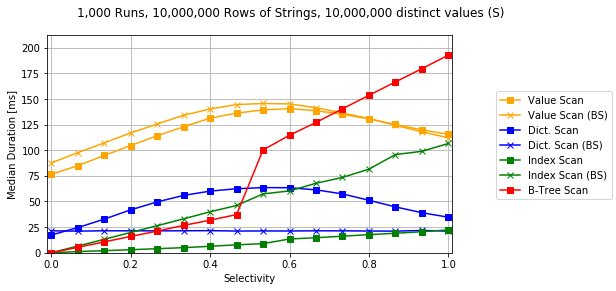

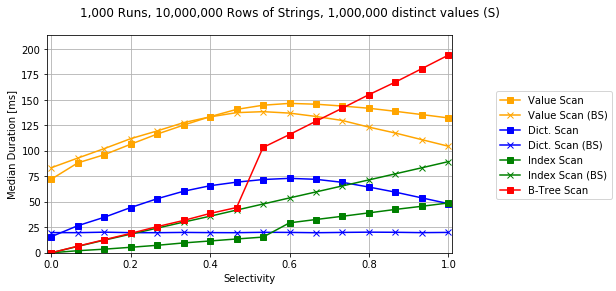

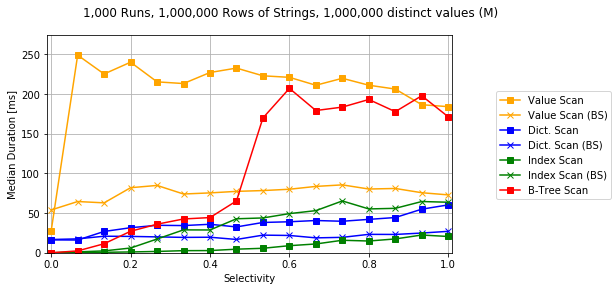

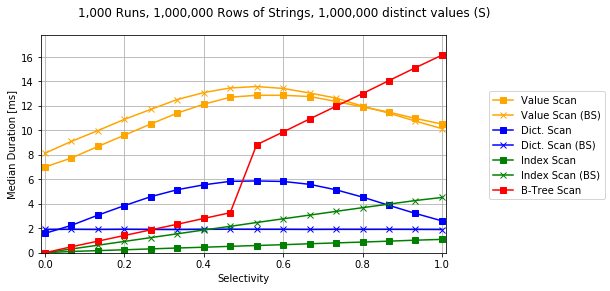

In [4]:
plots = []

files = [
    'int_10m_multi_10m_distinct.csv',
    'int_10m_multi_1m_distinct.csv',
    'int_10m_single_10m_distinct.csv',
    'int_10m_single_1m_distinct.csv',
    'int_1m_multi_1m_distict.csv',
    'int_1m_single_1m_distinct.csv',
    'string_10m_multi_10m_distinct.csv',
    'string_10m_multi_1m_distinct.csv',
    'string_10m_single_10m_distinct.csv',
    'string_10m_single_1m_distinct.csv',
    'string_1m_multi_1m_distinct.csv',
    'string_1m_single_1m_distinct.csv' ]

split_distinct_values = []
for i in files:
    num_val = i.split('_')[3]
    if num_val == '1m':
        split_distinct_values.append(1000000)
    elif num_val == '10m':
        split_distinct_values.append(10000000)
    else:
        raise ValueError('Please add row size: {}'.format(num_val))
    
split_files = ['./messungen/' + name for name in files]

for i in range(len(split_files)):
    df = get_df(split_files[i])
    row_type = 'Strings' if ('string' in split_files[i]) else 'Integers'
    comment = '(S)' if 'single' in split_files[i] else '(M)'
    plot = plot_df(df, row_type, split_distinct_values[i], operation_type="less_or_equals", comment=comment)
    plots.append(plot)

### Save plots if requested

In [5]:
if save_plots: 
    if file_type == 'pdf':
        with PdfPages("plots presentation.pdf") as pdf:
            for plot in plots: pdf.savefig(plot)
    elif file_type == 'png' or file_type == 'svg':
        for i in range(len(plots)):
            if file_type == 'png': plot.savefig("plot {}.png".format(i), format="png", dpi=300)
            else: plot.savefig("plot {}.svg".format(i), format="svg")
    else: raise ValueError('Unsupported file type: {}'.format(file_type))